# TO DO'S

 - Data augmentation
     - shift
     - mirror?? (maybe not)
     - PCA? (why not)
 - reduce overfitting
 - if outliers use robust_scale of skipy
 - check http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [271]:
import torch
import math

from torch import Tensor
from torch import optim
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn

from matplotlib import pyplot as plt

# for progress bar
from tqdm import tqdm, trange


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# for cross validation:
from sklearn.model_selection import KFold

# from the same folder:
# to load the data
import dlc_bci as bci
from models import *
import helpers

import numpy as np


SEED = 50

# IPython magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### test the imported data:

In [272]:
pow(2,3)

8

In [273]:
# PARAMETERS

#CRIT = 'MSE'
CRIT = 'cross'
noise_DA = False
n_splits_K_fold = 2

HD_SIGNAL = False
if HD_SIGNAL == True : SIGNAL_LENGTH = 500
elif HD_SIGNAL == False : SIGNAL_LENGTH = 50

In [274]:
def normalize_data(dataset):
    #print(dataset)
    #print('lalalala  ',dataset.shape)
    mu  = np.mean(dataset,axis=0)
    std = np.std(dataset,axis=0)
    return (dataset-mu)/std

train_input, test_input, train_target, test_target = helpers.get_data_as_numpy(HD_SIGNAL, CRIT)

train_input = normalize_data(train_input)
test_input = normalize_data(test_input)
    
print(train_input.mean())

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])
train --- mean 24.03, std: 41.49 target mean:  0.496835443038
test --- mean 21.69, std: 40.83 target mean:  0.51
1.56071e-08


In [275]:
mean = 0.0
std = 1.0 / 4
noised_signals = np.zeros(train_input.shape)
for i in range(train_input.shape[0]):
    noised_signals[i] = train_input[i] + np.random.normal(mean, std, train_input[i].shape)

if noise_DA:
    train_input  = np.concatenate((train_input, noised_signals), 0)
    train_target = np.concatenate((train_target, train_target), 0)
    
print(third_tensor.shape)

(632, 28, 50)


In [276]:
# K-fold cross validation
X = train_input
y = train_target
kf = KFold(n_splits=n_splits_K_fold)
kf.get_n_splits(X) 
train_indices, test_indices = kf.split(X)
for train_index, test_index in [train_indices, test_indices]:
    print('divided')

divided
divided


In [277]:


# create train / validation set and set everything to numpy arrays
#    train_input, val_input, train_target, val_target = train_test_split(
#        train_input, train_target, test_size=0.2, random_state=SEED)
    
# convert to variables
train_input, train_target = helpers.from_numpy_to_torch(train_input, train_target, CRIT)
test_input, test_target = helpers.from_numpy_to_torch(test_input, test_target, CRIT)

In [278]:
# final check
print(':::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
print( str( type(train_input) ), train_input.size() )
print( str( type(train_target) ), train_target.size() )
#print(train_input.mean())
print ('----------------------------------------------------------------')
print('train --- mean {:0.5f}, std: {:0.2f}'.format(train_input.data.mean(),train_input.data.std()),\
     'target mean: ',train_target.data.numpy().mean())
print('validation --- mean {:0.5f}, std: {:0.2f}'.format(val_input.data.mean(),val_input.data.std()),\
     'target mean: ',val_target.data.numpy().mean())
print('test --- mean {:0.5f}, std: {:0.2f}'.format(test_input.data.mean(),test_input.data.std()),\
     'target mean: ',test_target.data.numpy().mean())

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
<class 'torch.autograd.variable.Variable'> torch.Size([316, 28, 50])
<class 'torch.autograd.variable.Variable'> torch.Size([316])
----------------------------------------------------------------
train --- mean 0.00000, std: 1.00 target mean:  0.496835443038
validation --- mean -0.00000, std: 1.00 target mean:  0.51
test --- mean -0.00000, std: 1.00 target mean:  0.51


# Visualise the data

(28, 50)


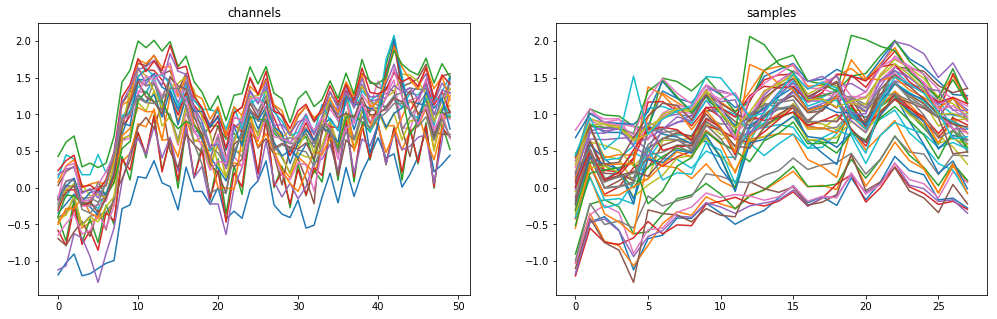

In [279]:
num_sample = 0

X = train_input.data.numpy()
Y = train_target.data.numpy()

print(X[num_sample].shape)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(17, 5))
ax1.plot(X[num_sample].transpose())
ax1.set_title('channels')

ax2.plot(X[num_sample])
ax2.set_title('samples')
plt.show()

(28, 50)
(10, 50)


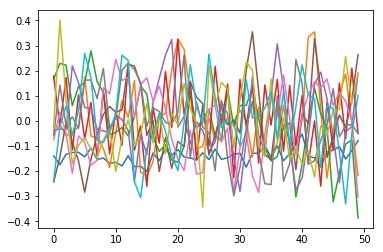

In [280]:
print (X[0].shape)
pca = PCA(n_components=10)
pca.fit(X[0])
X_pca = pca.components_
print(X_pca.shape)
plt.plot(X_pca.transpose())
plt.show()

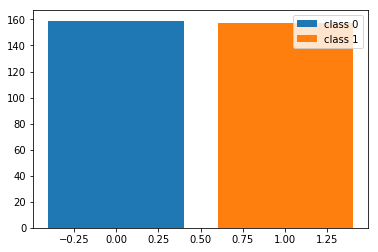

In [281]:
#check that the classes are equilibrated
unique, counts = np.unique(Y, return_counts=True)
to_plot = np.asarray((unique, counts))
for i in range(2):
    plt.bar(to_plot[0][i],to_plot[1][i],label='class '+str(i))
plt.legend()
plt.show()

### Baseline:

In [282]:
helpers.crappy_baselines(train_input = train_input, train_target=train_target,\
                         test_input = test_input, test_target = test_target,\
                         with_pca = False, nb_channels_pca = 10)

--------------  SVM BASELINE -----------------
(316, 1400) (316,)
(100, 1400) (100,)
38.0 %
--------------  KNN BASELINE -----------------
[0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0
 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0]
47.0 %


### Model:

In [283]:
"""def create_model_1():
    return Net(nb_hidden=100, nb_init_filters = 16, nb_convs=2, kernel_size=5, length_signal = SIGNAL_LENGTH )"""

class Net_seq(nn.Module):

    def __init__(self, hidden = 100, num_classes=2, nl='relu',iterations = 0,length_signal = SIGNAL_LENGTH ):
        
        super().__init__()
        #self.dropping_prob = 0.5
        if nl == 'leaky': f_non_linearity = nn.LeakyReLU(negative_slope=0.01,inplace=True)
        elif nl == 'tanh' : f_non_linearity =  nn.Tanh()
        elif nl == 'relu': f_non_linearity = nn.ReLU(inplace=True)
            
        filter_size = 3
        my_dropout = nn.Dropout(p=0.8)
        ################### layers ################
        
        f_layers = []
        f_layers.append(nn.Conv1d(28, 8, kernel_size=filter_size)) # 7 
        f_layers.append(f_non_linearity)
        
        f_layers.append(nn.Conv1d(8, 8, kernel_size=filter_size))
        f_layers.append(f_non_linearity)
        f_layers.append(nn.BatchNorm1d(8, affine=True))
        f_layers.append(my_dropout)
        #f_layers.append(nn.MaxPool1d(kernel_size=2))
        
        
        for i in range (iterations):
            f_layers.append(nn.Conv1d(4, 4, kernel_size=3))
            f_layers.append(f_non_linearity)
            f_layers.append(my_dropout)
        
        f_layers.append(nn.Conv1d(8, 16, kernel_size=filter_size))
        f_layers.append(f_non_linearity)
        f_layers.append(nn.BatchNorm1d(16, affine=True))
        f_layers.append(my_dropout)
        
        self.features = nn.Sequential(*f_layers)
        
        self.final_filters = length_signal - 3*(filter_size//2)*2 #-iterations*2
        self.final_length = 16
        
        c_layers = [] 
        c_layers.append(nn.Linear(self.final_filters*self.final_length, hidden))
        c_layers.append(nn.ReLU(inplace=True))
        #c_layers.append(nn.BatchNorm1d(hidden, eps=1e-05, momentum=0.1, affine=False))
        #c_layers.append(nn.Dropout(inplace=True))
        """c_layers.append(nn.Linear(hidden, hidden))
        c_layers.append(nn.ReLU(inplace=True))
        c_layers.append(my_dropout)
        c_layers.append(nn.Linear(hidden, hidden))
        c_layers.append(nn.ReLU(inplace=True))"""
        c_layers.append(nn.Linear(hidden, num_classes))
        #c_layers.append(nn.Softmax(dim=1))
        
        self.classifier = nn.Sequential(* c_layers)
        
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.final_filters*self.final_length)
        x = self.classifier(x)
        return x
        

# 14% with just 2 conv layers 26,16 filter 5 ;; 16,32, filter 5, 2 fcl with hidden = 100

def create_net_seq():
    return Net_seq()

### Helper Functions:

In [284]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size = mini_batch_size):
    nb_errors = 0
    for i in range(0, data_input.size(0)):
        model.train(False)
        if model.training == False:
            output = model.forward(data_input[i].view(1,28,SIGNAL_LENGTH))
        else : print('DROPING OUT IN TESTING')
        #print(output)
        _, predicted = torch.max(output.data, 1)                            
        true_val = data_target.data[i]
        if CRIT == 'MSE':
            true_val = true_val[0]
        predicted = predicted[0]
        #print(true_val)
        #print(predicted)
        if (true_val != predicted[0]):
            nb_errors += 1
        #print('LALALALALALA')
    return nb_errors

In [355]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.normal_(0.0, 0.02)
        #xavier(m.weight.data)
        #xavier(m.bias.data)
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def shuffle_data(input_, target_):
    my_randperm =torch.randperm(input_.size(0))
    return input_[my_randperm], target_[my_randperm]


def train_model(model, train_input, train_target,test_input, test_target, mini_batch_size,verbose=False):
    
    
    # initialise weight
    model.apply(weights_init)
    
    #optimizer = torch.optim.SGD(model.parameters(), lr = eta)
    optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=0)
    #optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-05)
    #optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    
    train_list = []
    test_list = []
    for e in trange(epochs):
    #for e in range(epochs):       
        train_input, train_target = shuffle_data(input_=train_input, target_=train_target)
        #torch.randperm(n, out=None, dtype=torch.int64, layout=torch.strided, device=None, requires_grad=False)
        for b in range(0, train_input.size(0), mini_batch_size):
            model.train(True)
            if model.training == True:
                output = model.forward(train_input[b:b+mini_batch_size])
            else : print('NOT TRAINING')
                
            loss = criterion(output, train_target[b:b+mini_batch_size])
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            """# for L1 normalisation
            for p in model.parameters():
                p.data -= p.data.sign() * p.data.abs().clamp(max = 0.001)"""

        if (e%10==0):
            train_errors = compute_nb_errors(model, data_input=train_input, data_target=train_target)
            test_errors = compute_nb_errors(model, data_input=test_input, data_target=test_target)
            train_list.append(train_errors)
            test_list.append(test_errors)
            if verbose == True:
                print('epoch #',e,\
                      'Train: {:0.2f}%'.format( train_errors/train_input.size(0)*100),\
                      'Val:  {:0.2f}%'.format(test_errors / test_input.size(0)*100),\
                      )
            #print('Loss:  {:0.5f} '.format(loss.data[0]))
    return train_list, test_list

            

### Parameters: 

In [356]:
mini_batch_size = 30
epochs = 1000

eta = 0.0001

if CRIT == 'MSE':
    criterion = nn.MSELoss()
elif CRIT == 'cross':
    criterion = nn.CrossEntropyLoss()

#torch.norm()
val_input=test_input
val_target = test_target

# Testing Zone:

In [357]:
"""def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        xavier(m.bias.data)"""

"""for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()"""

'for m in self.modules():\n            if isinstance(m, nn.Conv2d):\n                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels\n                m.weight.data.normal_(0, math.sqrt(2. / n))\n            elif isinstance(m, nn.BatchNorm2d):\n                m.weight.data.fill_(1)\n                m.bias.data.zero_()'

In [358]:
#model_list = [create_model_1, create_net_seq]
# for m in model_list:
m = create_net_seq
print(m.__name__)
model = m()

train_list_list = []
val_list_list   = []
for train_index, test_index in [train_indices, test_indices]:
    
    X_train, X_test = train_input.data.numpy()[train_index], train_input.data.numpy()[test_index]
    y_train, y_test = train_target.data.numpy()[train_index], train_target.data.numpy()[test_index]
    # reconvert them to variables
    X_train, y_train = helpers.from_numpy_to_torch(X_train, y_train, CRIT)
    X_test, y_test = helpers.from_numpy_to_torch(X_test, y_test, CRIT)

    train_list, val_list = train_model(model, train_input=X_train, train_target=y_train,\
                                        test_input = X_test, test_target = y_test,\
                                        mini_batch_size=mini_batch_size,verbose=False)
    train_list_list.append(train_list)
    val_list_list.append(val_list)

train_list_complete, test_list_complete = train_model(model, train_input, train_target,\
                                    test_input = test_input, test_target = test_target,\
                                    mini_batch_size=mini_batch_size,verbose=False)

test_errors = compute_nb_errors(model, data_input=test_input, data_target=test_target)
print('test: {:0.2f}%'.format( test_errors/test_input.size(0)*100) )

  0%|          | 0/1000 [00:00<?, ?it/s]

create_net_seq


100%|██████████| 1000/1000 [02:26<00:00,  6.85it/s]


test: 32.00%


test: 32.00%
val: 63.03%


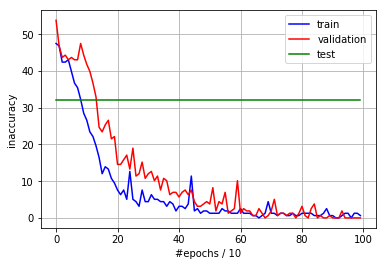

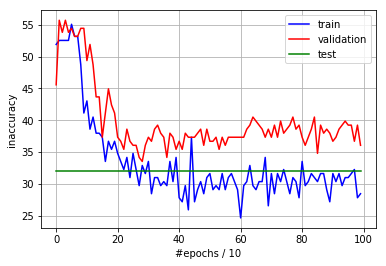

In [359]:
print('test: {:0.2f}%'.format( test_errors/test_input.size(0)*100) )
val = np.mean(val_list_list[:][-1])
print('val: {:0.2f}%'.format( val/val_input.size(0)*100) )

def plot_list(train_list,val_list):
    plt.plot(np.array(train_list)/train_input.size(0)*n_splits_K_fold*100,'b',label='train')
    plt.plot(np.array(val_list)/ train_input.size(0)*n_splits_K_fold*100,'r',label='validation')
    plt.plot(np.ones(np.array(train_list).shape)*test_errors/test_input.size(0)*100,'g',label='test')
    plt.legend()
    plt.grid()
    plt.xlabel('#epochs / 10')
    plt.ylabel('inaccuracy')
    plt.show()

for train_list,val_list in [train_list_list,val_list_list]:
    plot_list(train_list,val_list)

# GAN


In [134]:
# taken from https://github.com/pytorch/examples/blob/master/dcgan/main.py
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=True, help='cifar10 | lsun | imagenet | folder | lfw | fake')
parser.add_argument('--dataroot', required=True, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')

opt = parser.parse_args()
print(opt)

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

if opt.dataset in ['imagenet', 'folder', 'lfw']:
    # folder dataset
    dataset = dset.ImageFolder(root=opt.dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(opt.imageSize),
                                   transforms.CenterCrop(opt.imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
elif opt.dataset == 'lsun':
    dataset = dset.LSUN(root=opt.dataroot, classes=['bedroom_train'],
                        transform=transforms.Compose([
                            transforms.Resize(opt.imageSize),
                            transforms.CenterCrop(opt.imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
elif opt.dataset == 'cifar10':
    dataset = dset.CIFAR10(root=opt.dataroot, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
elif opt.dataset == 'fake':
    dataset = dset.FakeData(image_size=(3, opt.imageSize, opt.imageSize),
                            transform=transforms.ToTensor())
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

device = torch.device("cuda:0" if opt.cuda else "cpu")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
nc = 3


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

criterion = nn.BCELoss()

fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))


Using data [Data and variances]


TypeError: torch.mean received an invalid combination of arguments - got (torch.FloatTensor, int, keepdim=bool), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, int dim)
